In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
from pybullet_envs.bullet.kukaGymEnv import KukaGymEnv
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
import random
import os
from gym import spaces
import time
import pybullet as p
from pybullet_envs.bullet import kuka
import numpy as np
import pybullet_data
import pdb
import distutils.dir_util
import glob
from pkg_resources import parse_version
import gym

current_dir=C:\Users\Kami\anaconda3\envs\robot_grasping\lib\site-packages\pybullet_envs\bullet


In [3]:
env = KukaDiverseObjectEnv(urdfRoot=pybullet_data.getDataPath(),
                           actionRepeat=80,
                           isEnableSelfCollision=True,
                           renders=False,
                           isDiscrete=False,
                           maxSteps=15,
                           dv=0.06,
                           removeHeightHack=False,
                           blockRandom=0.,
                           cameraRandom=0,
                           width=64,
                           height=64,
                           numObjects=1,
                           isTest=False)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU IS AVAILABLE :D') 
else:  
    device = torch.device("cpu") 
    print('GPU not available')

GPU IS AVAILABLE :D


In [5]:
Transition = namedtuple('Transition',
                       ('state',
                       'action',
                       'next_state',
                       'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        "save a transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
class DQN(nn.Module):
    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, stride=1)
          
        self.fn1 = nn.Linear(7*7*32, 32)
        
        self.fn2 = nn.Linear(3, 32) # need to change this to 4
        
        self.fn3 = nn.Linear(32, 32)
        self.fn4 = nn.Linear(32, 1)
        
    def forward(self, s, a): # s is the observation, a is the action 
        s = s.to(device)
        a = a.to(device)
        
        s = F.relu(F.max_pool2d(self.conv1(s), 2))
        s = F.relu(F.max_pool2d(self.conv2(s), 2))
        s = F.relu(F.max_pool2d(self.conv3(s), 2))
        
        s = s.view(-1, 7*7*32) 
        s = F.relu(self.fn1(s))
        
        a = F.relu(self.fn2(a))
        
        val = torch.add(s, a)
        
        val = F.relu(self.fn3(val))
        
        return self.fn4(val)

In [7]:
env.reset()

BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 50

init_screen = env._get_observation()
screen_height, screen_width, _ = init_screen.shape

n_actions = 7 

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) 
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(50000)

In [8]:
steps_done = 0

In [3]:
class ContinuousDownwardBiasPolicy(object):
    def __init__(self, height_hack_prob=0.9):
        self._height_hack_prob = height_hack_prob
        self._action_space = spaces.Box(low=-1, high=1, shape=(3,))
    
    def sample_action(self, obs, explore_prob):
        dx, dy, dz = self._action_space.sample()
        if np.random.random() < self._height_hack_prob:
            dz = -1
        return [dx, dy, dz]
                

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE) 
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)

    # keep
    state_action_values = policy_net(state_batch, action_batch).gather(1, action_batch) 
    target_qvals = torch.zeros(BATCH_SIZE, device=device).reshape(BATCH_SIZE,1)

    # DDQN Update
    
    # random optimisation
    next_actions = torch.zeros(BATCH_SIZE, device=device).reshape(BATCH_SIZE,1)
    
    for ind, next_state in enumerate(next_state_batch):
        
        acts = torch.zeros(16, device=device).reshape(16,1)
        q_val = torch.zeros(16).reshape(16, 1)
        
        for j in range(16):
            # sample 16 actions uniformly at random
            acts[j] = env.action_space.sample()
            
            # evaluate these actions in the next state to get a vector of q values
            q_val = policy_net(next_state, acts[j]).detach()
            
        # pick action that returns greatest q value for this next_state
        idx = torch.argmax(q_val)
        next_actions[ind] = acts[idx]
        
        
    
#     next_actions = torch.max(policy_net(next_state_batch), dim=-1)[1].reshape(BATCH_SIZE,1)
    
    target_qvals[non_final_mask] = target_net(next_state_batch, next_actions).gather(1, next_actions).detach()
    
    # keep the following
    expected_state_action_values = (target_qvals * GAMMA) + reward_batch.unsqueeze(1)
    
    criterion = nn.SmoothL1Loss() 


    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model 
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [11]:
def get_state(state):
    state = state.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = state.float()
    return state.unsqueeze(0)

In [12]:
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [27]:
num_episodes = 1500 # already did 12500 steps, max 15 steps per episode, avg 7 steps per ep
success_rate = 0
episode_durations = []
eps_history = []
rewards = []
TD_errors = np.zeros(12500)
SAVE_EVERY = 500

for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = get_state(state)

    for t in count():
        # Select and perform an action
        action, eps = select_action(state)
        next_state, reward, done, _ = env.step(action.item()) 
        
        # record any success
        if reward == 1:
            success_rate += 1
        
        reward = torch.tensor([reward], device=device) # need to change reward from numpy float to tensor and send to device
        next_state = get_state(next_state)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # record MC error
        TD_error = reward + GAMMA*target_net(next_state).detach() - policy_net(state).detach()
        TD_errors[i_episode] = torch.sum(TD_error).item()
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done: 
            episode_durations.append(t + 1)
            plot_durations()
            break
            
    eps_history.append(eps)
    rewards.append(reward)
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    if i_episode % SAVE_EVERY == 0:
        torch.save(policy_net.state_dict(), 'Policy-net DDQN.pt')
        torch.save(target_net.state_dict(), 'Target-net DDQN.pt')
        
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [28]:
torch.save(policy_net.state_dict(), 'Policy-net DDQN final.pt')
torch.save(target_net.state_dict(), 'Target-net DDQN final.pt')

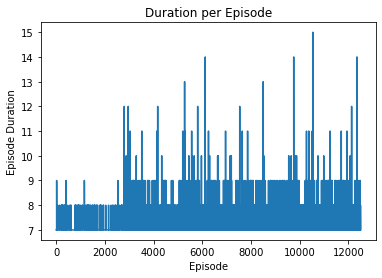

In [24]:
plt.plot(np.arange(len(episode_durations)), episode_durations)
plt.xlabel('Episode')
plt.ylabel('Episode Duration')
plt.title('Duration per Episode')
plt.show()

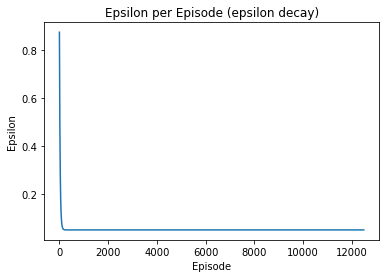

In [18]:
plt.plot(np.arange(len(eps_history)), eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon per Episode (epsilon decay)')
plt.show()

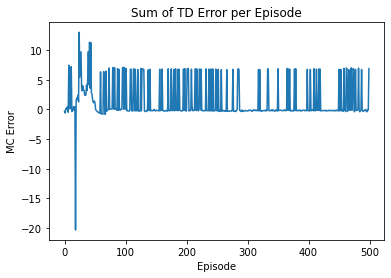

In [19]:
plt.plot(np.arange(len(TD_errors[:500])), TD_errors[:500]) 
plt.xlabel('Episode')
plt.ylabel('MC Error')
plt.title('Sum of TD Error per Episode')
plt.show()

In [20]:
for i in range(len(rewards)):
    rewards[i] = rewards[i].item()

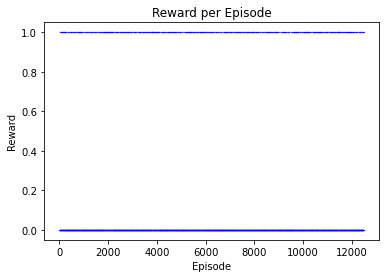

In [26]:
plt.plot(np.arange(len(rewards)), rewards, 'bo', markersize=.1)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()